In [1]:
#pip
!pip install torchvision

In [2]:
#imports
import pandas as pd
import os
import numpy as np
from numpy.distutils.misc_util import is_sequence
from bs4 import BeautifulSoup #this is to extract info from the xml, if we use it in the end
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import pickle

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler 
from sklearn.metrics import f1_score, precision_score, recall_score
import statistics 

import os
from datetime import datetime 
from pathlib import Path 


In [3]:
try:
    current_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") 
    dir_path = os.getcwd()
    directory = dir_path+"/"+current_time+"_NOTEBOOK"
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Creation of directory at {directory} successful')
except:
    print(f'Creation of directory at {directory} failed')


Creation of directory at /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK successful


In [4]:
file_output_path = directory+"/"

In [5]:
batch_size = 8
num_epochs = 1

In [6]:
# Get label and encode
def get_box(obj):
    xmin = float(obj.find('xmin').text)
    xmax = float(obj.find('xmax').text)
    ymin = float(obj.find('ymin').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == 'person' or obj.find('name').text == 'people':
        return 1
    if obj.find('name').text == 'cyclist':
        return 2
    else:
        return 0

# Generate the target location in the image
def generate_target(image_id,file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml') #probably will have to change this
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        # Creating the target for the box
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id

        return target

def OHE(label):
  if label == "People" or label== "Person":
      return 1
  elif label == "Cyclist":
      return 2
  else:
      return 0

def Recode(label):
  if label == 1:
      return "Person(s)"
  elif label == 2:
      return "Cyclist"
  else:
      return "N/A"

class FullImages(object):
    def __init__(self, transforms=None):
        #self.csv = pd.read_csv("frame_MasterList.csv")
        self.csv = pd.read_csv("frame_MasterList.csv").head(25)  # will always grab this
        self.csv_len = self.csv.shape[1]
        self.imgs = self.csv.image_path.tolist()
        self.imgs_len = len(self.imgs)
        self.transforms = transforms

    def __len__(self):
        return self.imgs_len
        #return self.csv_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.csv.loc[idx, 'image_path']
        annotation = self.csv.loc[idx, 'annotation_path']

        img = Image.open(img).convert("L")
        target = generate_target(idx, annotation)

        # label = self.labels[idx]
        # label = OHE(label)
        # label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


In [7]:
# Normalize
data_transform = transforms.Compose([#transforms.Resize((80,50)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5]
                                                          )])

# Collate images
def collate_fn(batch):
    return tuple(zip(*batch)) #will need adjusting when pathing is adjusted

dataset = FullImages(data_transform)
data_size = len(dataset)
print(f'Length of Dataset: {data_size}')

indices = list(range(data_size))
test_split = 0.2
split = int(np.floor(test_split * data_size))
#print(f'Length of Split Dataset: {split}')

train_indices, test_indices = indices[split:], indices[:split]
len_train_ind, len_test_ind = len(train_indices), len(test_indices)
print(f'Length of Train: {len_train_ind}; Length of Test: {len_test_ind}')


Length of Dataset: 25
Length of Train: 20; Length of Test: 5


In [8]:

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    sampler = train_sampler,
    collate_fn = collate_fn
)
len_dataloader = len(data_loader)
print(f'Length of train: {len_dataloader}')

data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = test_sampler, collate_fn = collate_fn)
len_testdataloader = len(data_loader_test)
print(f'Length of test: {len_testdataloader}')


Length of train: 3
Length of test: 1


In [9]:
# Check if GPU
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Instance segmentation is crucial in using the full images
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes)
    return model


In [10]:
test_i = 0
for test_imgs, test_annotations in data_loader_test:
    test_i += 1
    imgs_test = list(img_test.to(device) for img_test in test_imgs)
    annotations_test = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]
    

print(f'{len_dataloader} images in train data loader.')
print(f'{len_testdataloader} images in test data loader.')

3 images in train data loader.
1 images in test data loader.


In [11]:
#cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
model = get_model_instance_segmentation(3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params) #, lr = 0.005, weight_decay = 0.0005)

In [12]:

tot_ats = 0
epochs = 0
epoch_ats = []
epoch_losses = []
df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses}) 
for epoch in range(num_epochs):
    epochs += 1
    print(f'Epoch: {epochs}')
    model.train()
    epoch_loss = 0
    i = 0
    for train_imgs, train_annotations in data_loader:
        imgs = list(img.to(device) for img in train_imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        tot_ats += 1 
    
        epoch_loss += losses
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
    
    mean_epoch_loss = epoch_loss/i
    epoch_losses.append(mean_epoch_loss)
    epoch_ats.append(i)
    
    if epochs % 1 == 0:
        df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses})  
        #print(df)
        partial_name = "full_model_partial_" + str(epochs)     
        df.to_csv(file_output_path+partial_name+ "_losses.csv", index=False)
        torch.save(model.state_dict(), file_output_path+partial_name + ".pt") 
        print(f'Partial model and losses for epoch {file_output_path} saved to {directory}.')    
        
    # Update learning rate
    #lr_scheduler.step()

try:
    # Save training metrics
    full_name = "full_model_losses_" + str(epochs) + ".csv"
    df.to_csv(file_output_path+full_name, index=False)
    print(f'Full model losses for {epochs} epochs saved to {directory}.') 
except:
    pass

try:
    # Save model
    torch.save(model.state_dict(), file_output_path+'full_model.pt')
    print(f'Full model trained on {epochs} epochs saved to {directory}.')     
except:
    pass

print(f'Annotations Trained: {tot_ats}')

# model2 = get_model_instance_segmentation(3)
# model2.load_state_dict(torch.load(file_output_path+'full_model.pt'))
# model2.eval()
# model2.to(device)


Epoch: 1


Iteration: 1/3, Loss: 1.1491845846176147


Iteration: 2/3, Loss: 2.9491491317749023


Iteration: 3/3, Loss: 21.694013595581055


Partial model and losses for epoch /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK/ saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK.
Full model losses for 1 epochs saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK.
Full model trained on 1 epochs saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK.
Annotations Trained: 3


In [13]:
EPS = 1e-6 
master_csv = pd.read_csv("frame_MasterList.csv")

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [19]:
preds_train = model(train_imgs)
#print(preds_train)


Train predictions DO NOT EQUAL test predictions.


In [16]:
preds_test = model(test_imgs)
#print(preds_test)


Train predictions DO NOT EQUAL test predictions.


In [20]:
if preds_train == preds_test:
    print(f'Train predictions EQUAL test predictions.')
else:
    print(f'Train predictions DO NOT EQUAL test predictions.')

Train predictions DO NOT EQUAL test predictions.


100 prediction boxes made for 3 actual boxes in set01_V003_I00640


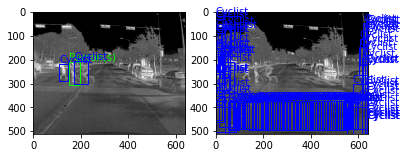

In [23]:
def plot_images(num, input):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    img_tensor = imgs[num]
    annotation = annotations[num]
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds_train[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        #print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[0].text(target_x, target_y, text, color=colors[value])
        ax[0].add_patch(rect)
        ix += 1
        

    ix = 0
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = prediction["labels"][ix]
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[1].text(target_x, target_y, text, color=colors[value])
        ax[1].add_patch(rect)
        ix += 1
        
    #figname = file_name+"_"+input+".png"
    #fig.savefig(figname)
    plt.show()


100 prediction boxes made for 3 actual boxes in set01_V003_I00640


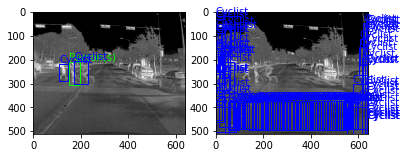

In [25]:
plot_images(0, "first")

In [53]:
# A predicted bounding box is considered correct if it overlaps more than 50% with a ground-truth bounding box, otherwise the bounding box is considered a false positive detection. Multiple detections are penalized. If a system predicts several bounding boxes that overlap with a single ground-truth bounding box, only one prediction is considered correct, the others are considered false positives.

### AFTER INTERIM: 
# Use get_iou to store set, video, frame, annotation boxes, pred boxes, lists of iou
# Dictionary like {cyclist: [IOU, IOU, IOU], people: [IOU, IOU]}

def plot_iou(num, input, test = False):
    fig, ax = plt.subplots(1)
    if test:
        identifier = "_Test"
        print(identifier)
        img_tensor = imgs_test[num]
        annotation = annotations_test[num]
        prediction = preds_test[num]
    else:
        identifier = "_Train"
        print(identifier)
        img_tensor = imgs[num]
        annotation = annotations[num]
        prediction = preds_train[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    annotation_boxes = annotation["boxes"].tolist()  
    
    ax.imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name+identifier
        text = Recode(value)
        colors = ["r", "r", "r"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1  

    ix = 0
    voc_iou = []
    print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input}')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)

        max_ix = iou_list.index(max_val)
        map_dict = {max_ix: max_val} 
        
        #iou_string = ', '.join((str(float) for float in iou_list))
        value = prediction["labels"][ix]
        text = json.dumps(map_dict)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1
    
    plt.show()
    
    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou)/len(voc_iou)
        fp = voc_iou.count(0)/len(voc_iou) * 100
        bp = sum((i > 0 and i < 0.5) for i in voc_iou)/len(voc_iou) * 100
        gp = sum((i >= 0.5) for i in voc_iou)/len(voc_iou) * 100
        print(f'{fp} false positives (IOU = 0)') 
        print(f'{bp} bad positives (0 < IOU < 0.5)')
        print(f'{gp} good positives (IOU >= 0.5)')
        print(f'Mean IOU: {mean_iou}')

    figname = output_name+"_"+input+".png"
    fig.savefig(file_output_path+figname)
    print(f'Figure {figname} saved to {directory}.')  


In [54]:
def get_iou(num, input, test = False):
    if test:
        identifier = "Test"
        annotation = annotations_test[num]
        prediction = preds_test[num]
    else:
        identifier = "Train"
        annotation = annotations[num]
        prediction = preds_train[num]
    
    annotation_boxes = annotation["boxes"].tolist()
    
    ix = 0
    for box in annotation["boxes"]:
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        ix += 1  

    ix = 0
    voc_iou = []
    print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input}')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)
        ix += 1
        
    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou)/len(voc_iou)
    
    return [mean_iou, voc_iou]


100 prediction boxes made for 3 actual boxes in set01_V003_I00630 for Test with note first


0.002681916918722267

In [57]:
plot_iou(0, "first", True)
#plot_iou(len_testdataloader, "last", True)

#plot_iou(0, "first", False)
#plot_iou(len_dataloader, "last", False)


100 prediction boxes made for 3 actual boxes in set01_V003_I00630 for Test with note first


0.002681916918722267

In [59]:
get_iou(0, "first", True)[0]


100 prediction boxes made for 3 actual boxes in set01_V003_I00630 for Test with note first


0.002681916918722267

In [ ]:
iou_df_train = pd.DataFrame(columns=["Train_Mean_IOU", "IOU_List"])
for train_pred in range(0, len_dataloader):
    iou_function = get_iou(train_pred, "first", False)
    len_df = len(iou_df_train)
    iou_df_train.loc[len_df,:] = iou_function
    try:
        if train_pred % 50 == 0:
            partial_name = "partial_iou_TRAIN" + str(train_pred) + "_images.csv" 
            iou_df_train.to_csv(file_output_path+partial_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_train)} images saved to {directory}.') 
    except:
        pass
        
iou_df_train_name = "full_iou_TRAIN_" + str(epochs) + ".csv"
iou_df_train.to_csv(file_output_path+iou_df_train_name, index=False)
print(f'Full train IOUs for {len(iou_df_train)} images saved to {directory}.') 


,Train_Mean_IOU,IOU_List
1,0.00230248,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [62]:
iou_df_train.sort_values(by='Train_Mean_IOU', ascending=False).head(3)

,Train_Mean_IOU,IOU_List
1,0.00230248,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
iou_df_test = pd.DataFrame(columns=["Test_Mean_IOU", "IOU_List"])
for test_pred in range(0, len_testdataloader):
    iou_function = get_iou(test_pred, "test", False)
    len_df = len(iou_df_test)
    iou_df_test.loc[len_df,:] = iou_function
    try:
        if test_pred % 50 == 0:
            partial_name = "partial_iou_TRAIN" + str(test_pred) + "_images.csv" 
            iou_df_test.to_csv(file_output_path+partial_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_test)} images saved to {directory}.') 
    except:
        pass
        
iou_df_test_name = "full_iou_TEST_" + str(epochs) + ".csv"
iou_df_test.to_csv(file_output_path+iou_df_test_name, index=False)
print(f'Full train IOUs for {len(iou_df_test)} images saved to {directory}.') 


,Test_Mean_IOU,IOU_List
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [64]:
iou_df_test.sort_values(by='Test_Mean_IOU', ascending=False).head(3)

,Test_Mean_IOU,IOU_List
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [65]:
max_train_ix = iou_df_train[iou_df_train['Train_Mean_IOU'] == iou_df_train['Train_Mean_IOU'].max()].index.tolist()[0]
max_test_ix = iou_df_test[iou_df_test['Test_Mean_IOU'] == iou_df_test['Test_Mean_IOU'].max()].index.tolist()[0]


_Train
100 prediction boxes made for 3 actual boxes in set01_V003_I00627_Train for _Train with note best_train


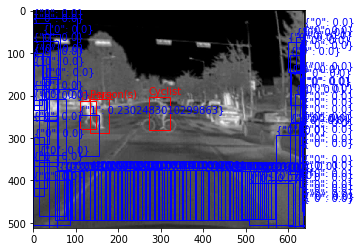

99.0 false positives (IOU = 0)
1.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.002302483010299863


Figure set01_V003_I00627_Train_best_train.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK.


In [66]:
plot_iou(max_train_ix, "best_train", False)


_Test
100 prediction boxes made for 3 actual boxes in set01_V003_I00630_Test for _Test with note best_test


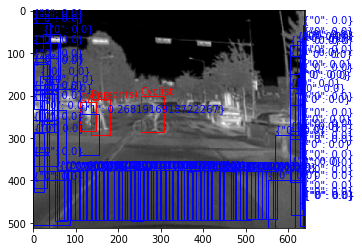

99.0 false positives (IOU = 0)
1.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.002681916918722267


Figure set01_V003_I00630_Test_best_test.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_10-07_44_07_PM_NOTEBOOK.


In [67]:
plot_iou(max_test_ix, "best_test", True)


In [68]:
print(f'Train Mean IOU: {iou_df_train["Train_Mean_IOU"].mean()}')
print(f'Test Mean IOU: {iou_df_test["Test_Mean_IOU"].mean()}')

Train Mean IOU: 0.0007674943367666211
Test Mean IOU: 0.0
